# Feature finding in 3D confocal images

Confocal microscopy is a techique that is able to make image slices of your sample. New developments (spinning disk scanning, resonant mirrors) have made this technique sufficiently fast for 3D tracking. Commonly, the sample is mounted on a piezo stage that is able to quickly scan the sample in Z direction. In this way, sequences of Z pictures can be made. By repeating this, the sample can be followed real-time in 3D.

Because of the different techniques used for XY and Z resolution, pixel sizes in these directions are mostly not equal. It is easy to extend the method of Crocker & Grier to 3 dimensions with different feature sizes. Trackpy can do this from version v0.3; the only thing you need to do is load your images as 3 dimensional numpy arrays and supply a tuple value for diameter, describing feature size in each dimension.

First, we initalize IPython and load the required packages. PIMS and Trackpy v0.3 are required.

## Setup IPython, pims, trackpy

In [34]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('figure',  figsize=(10, 6))
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp
import os

## Import 3D images

We make use of `ImageSequenceND`. This reader class searches for files matching a certain search string. The filename should contain indentifiers for each axis (dimension). For example `"demo_t001_z001.png"` contains identifiers `t` and `z`. We set the returned image axes to `zyx` and the iterating axis to `t`. In this way we get 3D images indexed by `t`.

For this tutorial, the images are inside a zipfile. You can extract the images from the specified archive to check them out.

In [35]:
path = r'C:\Eric\Xerox Data\30um gap runs\6-22-17 0.3333Hz\1.4V sweep pauses\ampsweep_pre_train\3.0V\u_combined\*.tif';
frames = pims.ImageSequenceND(path, axes_identifiers = ['t', 'z'])
# frames.bundle_axes = ['z', 'y', 'x']    # Not actually necessary. Already bundles z,y,x
frames.iter_axes = 't'
frames

<ImageSequenceND>
Source: C:\Eric\Xerox Data\30um gap runs\6-22-17 0.3333Hz\1.4V sweep pauses\ampsweep_pre_train\3.0V\u_combined\*.tif
Axes: 4
Axis 'y' size: 512
Axis 'x' size: 512
Axis 'z' size: 50
Axis 't' size: 6
Pixel Datatype: uint8

The time-index of the first frame is always 0, regardless of the index in the filename. We can use `pims` 3d scrollable stack feature to display a 3D image. Use the scroll wheel to scroll through the focal planes.

This feature will not work online, download the example and run it yourself to checkout the scrollable stack feature.

In [36]:
# frames[1]

## Feature finding

Now we can use `trackpy.locate` to generate a table (a pandas `DataFrame`) of the feature coordinates. `locate` only requires a feature diameter. This needs to be an odd integer and can be specified for each dimension seperately. The order of dimensions is the same as the order of the image array, typically (z, y, x).

In [37]:
# features = tp.locate(frames[0], diameter=(15, 15, 15), invert = False, separation = (7,7,7), preprocess = False, minmass = 60000) 
# # preprocess = False disables bandpass filtering by trackpy (do my own first instead)
# features.head()  # displays first 5 rows
# print('Features found: {0}'.format(len(features)))

## Batch processing

We use the optimized settings and iterate through the full movie.

In [38]:
f = tp.batch(frames, diameter=(15, 15, 15), invert = False, separation = (7,7,7), preprocess = False, minmass = 60000)

Frame 5: 1442 features


In [39]:
f.head()

,x,y,z,mass,size,ecc,signal,raw_mass,ep,frame
0,484.752519,34.253564,6.916422,120163.0,4.980416,NaN,144.0,120163.0,NaN,0
1,492.173408,49.754112,6.337741,109424.0,5.047752,NaN,131.0,109424.0,NaN,0
2,30.706042,53.522851,6.785843,92292.0,5.016628,NaN,110.0,92292.0,NaN,0
3,353.361230,61.541657,6.586595,135811.0,5.045837,NaN,145.0,135811.0,NaN,0
4,292.988228,71.440582,8.232312,118668.0,5.001533,NaN,133.0,118668.0,NaN,0


In [40]:
#Save the data to csv file
f.to_csv(path[:-5] + 'positions.csv')

## Linking

The linking features of trackpy support an arbitrary number of dimensions. The argument pos_columns will determine which and how many dimensions will be used. The standard set of columns is `['x', 'y']`. For 3d we have to set this to `['x', 'y', 'z']`. 
Linking treats all dimensions equally. For this example we are using a file with unequal pixel sizes: 0.21 microns in XY and 0.75 microns in Z, so we first define new columns in units of microns.

In [41]:
f['xum'] = f['x'] * 0.125
f['yum'] = f['y'] * 0.125
f['zum'] = f['z'] * 0.12

Experimentally, there is a tradeoff between framerate and z pixel size. If you want to have higher z resolution, you scan slower and your framerate goes down. In this specific experiment the z resolution is low, so that we are able to link particles between subsequent frames. We try several linking distances here.

Frame 5: 1442 trajectories present


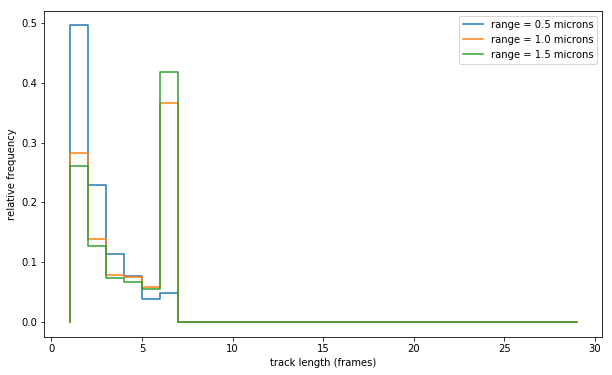

In [42]:
for search_range in [0.5, 1.0, 1.5]:
    linked = tp.link_df(f, search_range, pos_columns=['xum', 'yum', 'zum'])
    hist, bins = np.histogram(np.bincount(linked.particle.astype(int)),
                              bins=np.arange(30), normed=True)
    plt.step(bins[1:], hist, label='range = {} microns'.format(search_range))
plt.ylabel('relative frequency')
plt.xlabel('track length (frames)')
plt.legend();

## Mean squared displacement

We use a search range of 2.0 microns, because there is no significant improvement between 2.0 and 2.5 microns.

In [43]:
linked = tp.link_df(f, 1.0, pos_columns=['xum', 'yum', 'zum'])

Frame 5: 1442 trajectories present


In [44]:
# linked.head()

#Save the data to csv file
linked.to_csv(path[:-5] + 'linked.csv');

With the trajectories we can calculate the mean squared displacement. To calculate the mean squared displacement from all three dimensions, we need to tell trackpy which position columns to use. It defaults to `['x', 'y']`.

We specify `mpp=1` because we have already transformed our data to microns.

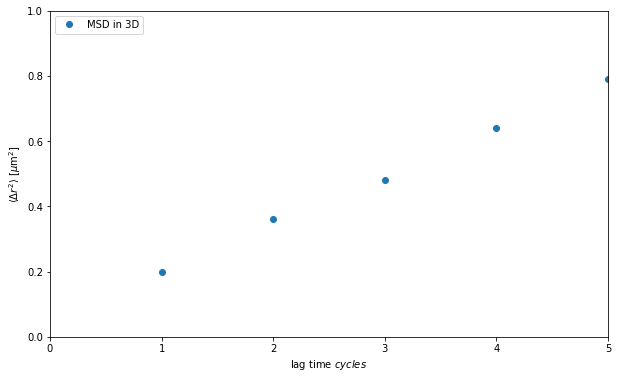

In [48]:
msd3D = tp.emsd(linked, mpp=1, fps=1, max_lagtime=20,
                pos_columns=['xum', 'yum', 'zum'])
ax = msd3D.plot(style='o', label='MSD in 3D')
ax.set_ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
ax.set_xlabel('lag time $cycles$')
ax.set_xlim(0, 5)
ax.set_ylim(0, 1)
ax.legend(loc='upper left');

In [49]:
#Save the msd to csv file
msd3D.to_csv(path[:-5] + 'msd3D.csv');

lagt
1.0    0.198003
2.0    0.360222
3.0    0.480645
4.0    0.641330
5.0    0.791044
Name: msd, dtype: float64


The mean squared displacement in three dimensional Brownian motion is described by the following relation:

$$\langle x^2 \rangle = 6 D t$$

Let's do a fit and calculate the diffusion constant!

The diffusion constant is 0.03 μm²/s


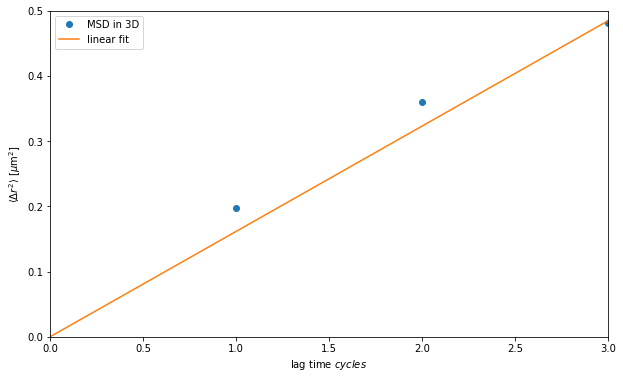

In [46]:
slope = np.linalg.lstsq(msd3D.index[:, np.newaxis], msd3D)[0][0]

ax = msd3D.plot(style='o', label='MSD in 3D')
ax.plot(np.arange(20), slope * np.arange(20), label='linear fit')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $cycles$')
ax.set(xlim=(0, 3), ylim=(0, 0.5))
ax.legend(loc='upper left')
print(r'The diffusion constant is {0:.2f} μm²/s'.format(slope / 6))